###**For import module**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

###Get Data

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip file.zip

unzip:  cannot find or open file.zip, file.zip.zip or file.zip.ZIP.


In [ ]:
#For import picture file
import zipfile

# Download zip file of dataset
zip_ref = zipfile.ZipFile("dataset3.zip", "r")
zip_ref.extractall()
zip_ref.close()
# Unzip the downloaded file

In [ ]:
import os
for dirpath, dirnames, filenames in os.walk("dataset2"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'dataset2'.
There are 3 directories and 0 images in 'dataset2/validate'.
There are 0 directories and 5 images in 'dataset2/validate/BetaAgonist'.
There are 0 directories and 4 images in 'dataset2/validate/Parasite'.
There are 0 directories and 20 images in 'dataset2/validate/Pork'.
There are 3 directories and 0 images in 'dataset2/train'.
There are 0 directories and 29 images in 'dataset2/train/BetaAgonist'.
There are 0 directories and 32 images in 'dataset2/train/Parasite'.
There are 0 directories and 104 images in 'dataset2/train/Pork'.
There are 3 directories and 0 images in 'dataset2/test'.
There are 0 directories and 5 images in 'dataset2/test/BetaAgonist'.
There are 0 directories and 4 images in 'dataset2/test/Parasite'.
There are 0 directories and 20 images in 'dataset2/test/Pork'.


In [ ]:
# for seperate trainset validateset testset
train_dir = "dataset2/train"
validate_dir = "dataset2/validate"
test_dir = "dataset2/test"

In [ ]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['BetaAgonist' 'Parasite' 'Pork']


In [ ]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (200, 267, 3)


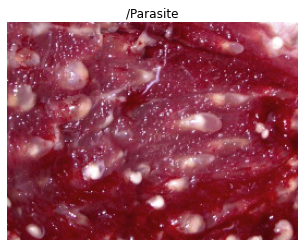

In [ ]:
import random
img = view_random_image(target_dir=test_dir,
                        target_class="/Parasite") # get a random class name

###Preprocessing Data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical') # changed to categorical

validate_data = train_datagen.flow_from_directory(validate_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 165 images belonging to 3 classes.
Found 29 images belonging to 3 classes.
Found 29 images belonging to 3 classes.


**Data Argumentation**

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2, # rotate the image slightly
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='categorical',
                                                                   shuffle=False)

print("Validate")
validate_data = test_datagen.flow_from_directory(validate_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='categorical')

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='categorical')

Augmented training images:
Found 165 images belonging to 3 classes.
Validate
Found 29 images belonging to 3 classes.
Unchanged test images:
Found 29 images belonging to 3 classes.


###Train Dataset

In [ ]:
#We can use the same model (TinyVGG) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Create our model (a clone of model_8, except to be multi-class)
model = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

#!!! Dense amount of class
# Compile the model
model.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history = model.fit(train_data, # now 10 different classes 
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=validate_data,
                        validation_steps=len(validate_data)) # can divide with batch

Epoch 1/5
6/6 [==============================] - 33s 660ms/step - loss: 1.6205 - accuracy: 0.4788 - val_loss: 1.2056 - val_accuracy: 0.1724
Epoch 2/5
6/6 [==============================] - 3s 426ms/step - loss: 0.9837 - accuracy: 0.5394 - val_loss: 0.8113 - val_accuracy: 0.6897
Epoch 3/5
6/6 [==============================] - 3s 427ms/step - loss: 0.8696 - accuracy: 0.6303 - val_loss: 0.8206 - val_accuracy: 0.6897
Epoch 4/5
6/6 [==============================] - 3s 398ms/step - loss: 0.8515 - accuracy: 0.6303 - val_loss: 0.8059 - val_accuracy: 0.6897
Epoch 5/5
6/6 [==============================] - 3s 426ms/step - loss: 0.8222 - accuracy: 0.6303 - val_loss: 0.8356 - val_accuracy: 0.6897


###Test model

In [ ]:
model.evaluate(test_data)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


1/1 [==============================] - 0s 426ms/step - loss: 0.8127 - accuracy: 0.6897


[0.8126906156539917, 0.6896551847457886]

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

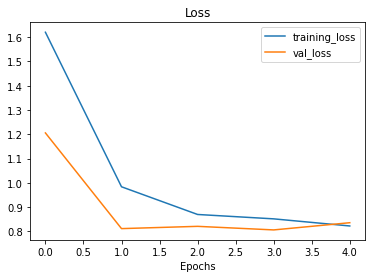

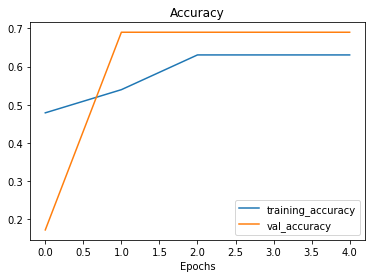

In [ ]:
plot_loss_curves(history)

###Train Model 2

In [ ]:
# I want to test Resnet and EffNet

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNet0 feature vector
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=(224, 224)+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

**Resnetmodel**

In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_augmented.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_augmented,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_augmented),
                                  validation_data=validate_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20210824-161832
Epoch 1/5
6/6 [==============================] - 13s 1s/step - loss: 1.4536 - accuracy: 0.4545 - val_loss: 1.1620 - val_accuracy: 0.4828
Epoch 2/5
6/6 [==============================] - 5s 788ms/step - loss: 1.0014 - accuracy: 0.6121 - val_loss: 0.9886 - val_accuracy: 0.6207
Epoch 3/5
6/6 [==============================] - 5s 794ms/step - loss: 0.8911 - accuracy: 0.6424 - val_loss: 0.9081 - val_accuracy: 0.7241
Epoch 4/5
6/6 [==============================] - 5s 771ms/step - loss: 0.7987 - accuracy: 0.7030 - val_loss: 0.8556 - val_accuracy: 0.7241
Epoch 5/5
6/6 [==============================] - 5s 733ms/step - loss: 0.7347 - accuracy: 0.7455 - val_loss: 0.8218 - val_accuracy: 0.6897


###Test model 2

In [ ]:
resnet_model.evaluate(test_data)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


1/1 [==============================] - 1s 560ms/step - loss: 0.5843 - accuracy: 0.7586


[0.5842878818511963, 0.7586206793785095]

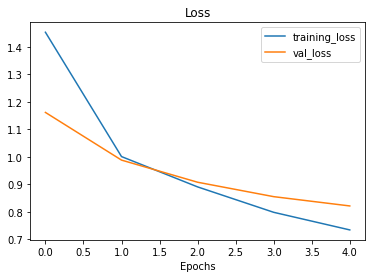

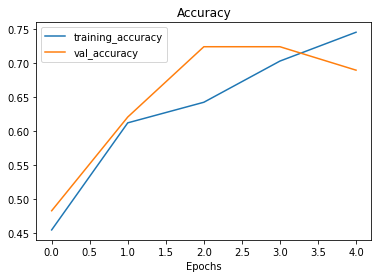

In [ ]:
plot_loss_curves(resnet_history)

###Train model 3

In [ ]:
# Create model
resnet_model = create_model(efficientnet_url, num_classes=train_data_augmented.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_augmented,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_augmented),
                                  validation_data=validate_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20210824-161923
Epoch 1/5
6/6 [==============================] - 19s 2s/step - loss: 1.0616 - accuracy: 0.5212 - val_loss: 0.8067 - val_accuracy: 0.6897
Epoch 2/5
6/6 [==============================] - 5s 768ms/step - loss: 0.8246 - accuracy: 0.7091 - val_loss: 0.7370 - val_accuracy: 0.6897
Epoch 3/5
6/6 [==============================] - 4s 760ms/step - loss: 0.7652 - accuracy: 0.6606 - val_loss: 0.6997 - val_accuracy: 0.7241
Epoch 4/5
6/6 [==============================] - 5s 698ms/step - loss: 0.7188 - accuracy: 0.6788 - val_loss: 0.6630 - val_accuracy: 0.7241
Epoch 5/5
6/6 [==============================] - 5s 808ms/step - loss: 0.6749 - accuracy: 0.7091 - val_loss: 0.6340 - val_accuracy: 0.7586


In [ ]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_augmented.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [ ]:
# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_augmented, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_augmented),
                                              validation_data=validate_data,
                                              validation_steps=len(validate_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20210824-162017
Epoch 1/5
6/6 [==============================] - 18s 2s/step - loss: 1.0208 - accuracy: 0.5515 - val_loss: 0.8741 - val_accuracy: 0.6207
Epoch 2/5
6/6 [==============================] - 5s 748ms/step - loss: 0.8958 - accuracy: 0.6242 - val_loss: 0.7509 - val_accuracy: 0.6552
Epoch 3/5
6/6 [==============================] - 4s 687ms/step - loss: 0.8304 - accuracy: 0.6485 - val_loss: 0.7052 - val_accuracy: 0.6897
Epoch 4/5
6/6 [==============================] - 5s 755ms/step - loss: 0.7289 - accuracy: 0.6545 - val_loss: 0.6703 - val_accuracy: 0.6897
Epoch 5/5
6/6 [==============================] - 4s 757ms/step - loss: 0.6783 - accuracy: 0.6727 - val_loss: 0.6335 - val_accuracy: 0.7241


In [ ]:
efficientnet_model.evaluate(test_data)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


1/1 [==============================] - 1s 501ms/step - loss: 0.7042 - accuracy: 0.6897


[0.704247772693634, 0.6896551847457886]

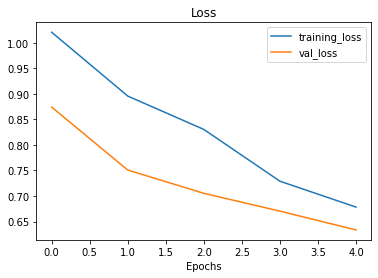

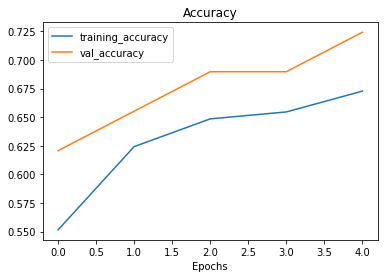

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
# Fit EfficientNet model 
efficientnet_history2 = efficientnet_model.fit(train_data_augmented, # only use 10% of training data
                                              epochs=10, # train for 5 epochs
                                              steps_per_epoch=len(train_data_augmented),
                                              validation_data=validate_data,
                                              validation_steps=len(validate_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20210824-162056
Epoch 1/10
6/6 [==============================] - 7s 1s/step - loss: 0.6230 - accuracy: 0.7333 - val_loss: 0.6002 - val_accuracy: 0.7586
Epoch 2/10
6/6 [==============================] - 4s 749ms/step - loss: 0.5571 - accuracy: 0.7697 - val_loss: 0.5726 - val_accuracy: 0.7241
Epoch 3/10
6/6 [==============================] - 4s 684ms/step - loss: 0.5400 - accuracy: 0.7939 - val_loss: 0.5439 - val_accuracy: 0.7931
Epoch 4/10
6/6 [==============================] - 4s 718ms/step - loss: 0.5338 - accuracy: 0.7758 - val_loss: 0.5191 - val_accuracy: 0.7931
Epoch 5/10
6/6 [==============================] - 4s 689ms/step - loss: 0.4581 - accuracy: 0.8061 - val_loss: 0.5004 - val_accuracy: 0.7931
Epoch 6/10
6/6 [==============================] - 4s 757ms/step - loss: 0.4505 - accuracy: 0.8424 - val_loss: 0.4815 - val_accuracy: 0.7586
Epoch 7/10
6/6 [==============================] - 5s 692ms/step - loss: 0.4247 - acc

In [ ]:
efficientnet_model.evaluate(test_data)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


1/1 [==============================] - 0s 495ms/step - loss: 0.4837 - accuracy: 0.7586


[0.4837391972541809, 0.7586206793785095]

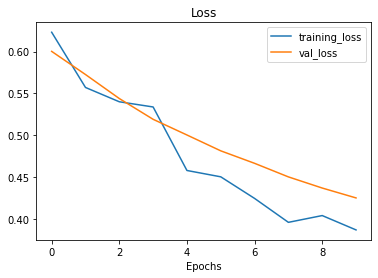

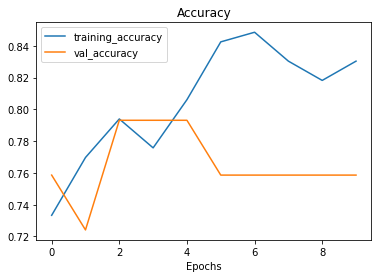

In [ ]:
plot_loss_curves(efficientnet_history2)

In [ ]:
efficientnet_model.save("/content/gdrive/MyDrive/Model_Classify_Two")

KeyboardInterrupt: ignored

In [ ]:
efficientnet_model.save("Model_Classify_Two")

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

###Train model 4

In [ ]:
# Fit EfficientNet model 
efficientnet_history3 = efficientnet_model.fit(train_data_augmented, # only use 10% of training data
                                              epochs=20, # train for 5 epochs
                                              steps_per_epoch=len(train_data_augmented),
                                              validation_data=validate_data,
                                              validation_steps=len(validate_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20210824-162255
Epoch 1/20
6/6 [==============================] - 6s 1s/step - loss: 0.3680 - accuracy: 0.8424 - val_loss: 0.4132 - val_accuracy: 0.7586
Epoch 2/20
6/6 [==============================] - 5s 803ms/step - loss: 0.3392 - accuracy: 0.8909 - val_loss: 0.4055 - val_accuracy: 0.8276
Epoch 3/20
6/6 [==============================] - 4s 730ms/step - loss: 0.3338 - accuracy: 0.8909 - val_loss: 0.3944 - val_accuracy: 0.8276
Epoch 4/20
6/6 [==============================] - 4s 695ms/step - loss: 0.3135 - accuracy: 0.8909 - val_loss: 0.3839 - val_accuracy: 0.8276
Epoch 5/20
6/6 [==============================] - 4s 862ms/step - loss: 0.3170 - accuracy: 0.8788 - val_loss: 0.3762 - val_accuracy: 0.8276
Epoch 6/20
6/6 [==============================] - 5s 792ms/step - loss: 0.3134 - accuracy: 0.9091 - val_loss: 0.3692 - val_accuracy: 0.8621
Epoch 7/20
6/6 [==============================] - 5s 747ms/step - loss: 0.2899 - acc

In [ ]:
efficientnet_model.evaluate(test_data)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


1/1 [==============================] - 1s 534ms/step - loss: 0.3501 - accuracy: 0.9310


[0.35014474391937256, 0.931034505367279]

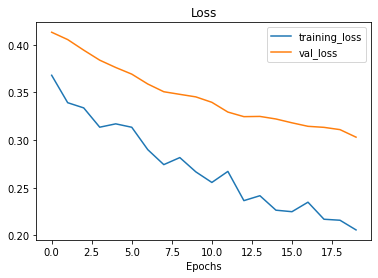

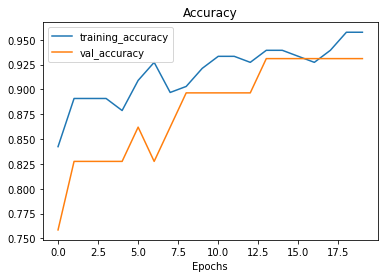

In [ ]:
plot_loss_curves(efficientnet_history3)

In [ ]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 3)                 3843      
Total params: 4,053,407
Trainable params: 3,843
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficientnet_model.save("/content/gdrive/MyDrive/Model_Classify_Three")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Model_Classify_Three/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Model_Classify_Three/assets


In [ ]:
# Fit EfficientNet model 
efficientnet_history3 = efficientnet_model.fit(train_data_augmented, # only use 10% of training data
                                              epochs=100, # train for 5 epochs
                                              steps_per_epoch=len(train_data_augmented),
                                              validation_data=validate_data,
                                              validation_steps=len(validate_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20210824-170935
Epoch 1/100
6/6 [==============================] - 6s 1s/step - loss: 0.1936 - accuracy: 0.9455 - val_loss: 0.2946 - val_accuracy: 0.9310
Epoch 2/100
6/6 [==============================] - 5s 699ms/step - loss: 0.2009 - accuracy: 0.9515 - val_loss: 0.2942 - val_accuracy: 0.9310
Epoch 3/100
6/6 [==============================] - 5s 765ms/step - loss: 0.2071 - accuracy: 0.9515 - val_loss: 0.2909 - val_accuracy: 0.9310
Epoch 4/100
6/6 [==============================] - 5s 739ms/step - loss: 0.1757 - accuracy: 0.9636 - val_loss: 0.2904 - val_accuracy: 0.9310
Epoch 5/100
6/6 [==============================] - 5s 745ms/step - loss: 0.1922 - accuracy: 0.9636 - val_loss: 0.2825 - val_accuracy: 0.9310
Epoch 6/100
6/6 [==============================] - 4s 681ms/step - loss: 0.1811 - accuracy: 0.9515 - val_loss: 0.2832 - val_accuracy: 0.9310
Epoch 7/100
6/6 [==============================] - 4s 865ms/step - loss: 0.176

In [ ]:
efficientnet_model.evaluate(test_data)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


1/1 [==============================] - 1s 537ms/step - loss: 0.2150 - accuracy: 0.9310


[0.21504506468772888, 0.931034505367279]

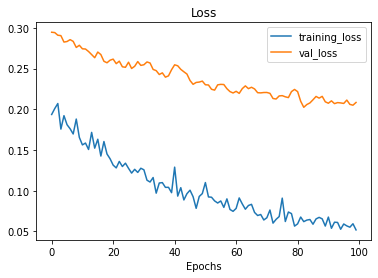

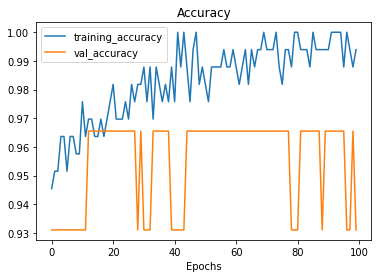

In [ ]:
plot_loss_curves(efficientnet_history3)

In [ ]:
S